## Import Necessary Packages

In [1]:
import os
import torch
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import proplot as pplt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_squared_log_error
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

/global/homes/s/sferrett/.conda/envs/monsoon-sr/lib/python3.10/site-packages/proplot/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg


## Functions

In [2]:
def load(varname):
    data = xr.open_dataset('/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed/LR_ERA5_IMERG_pr_bl_terms.nc')
    return data[varname].load()

def log_normalize(data,c=1.0):
    '''Logarithmic normalization: X' = ln(X+c), where X is the precipitation data, and c is a constant to handle 0 values'''
    normdata = np.log(data+c)
    return normdata

def inverse_log_normalize(normdata,c=1.0):
    data = np.exp(normdata)-c
    return data

def prepare(inputs,target,testsize):
    inputs   = [inputs] if not isinstance(inputs,list) else inputs
    combined = xr.merge([*inputs,target])
    df = combined.to_dataframe().reset_index()
    df = df.sort_values('time')
    x  = df[[i.name for i in inputs]]
    y  = df[[target.name]]
    xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=testsize,shuffle=False)
    return xtrain,xtest,ytrain,ytest

## Load Data

In [3]:
bl  = load('bl')
pr  = load('pr')
prlog = log_normalize(pr,c=1.0)

## Exploratory Plots

In [4]:
x    = bl.values.flatten()
y    = pr.values.flatten()
ylog = prlog.values.flatten()
bins = 100

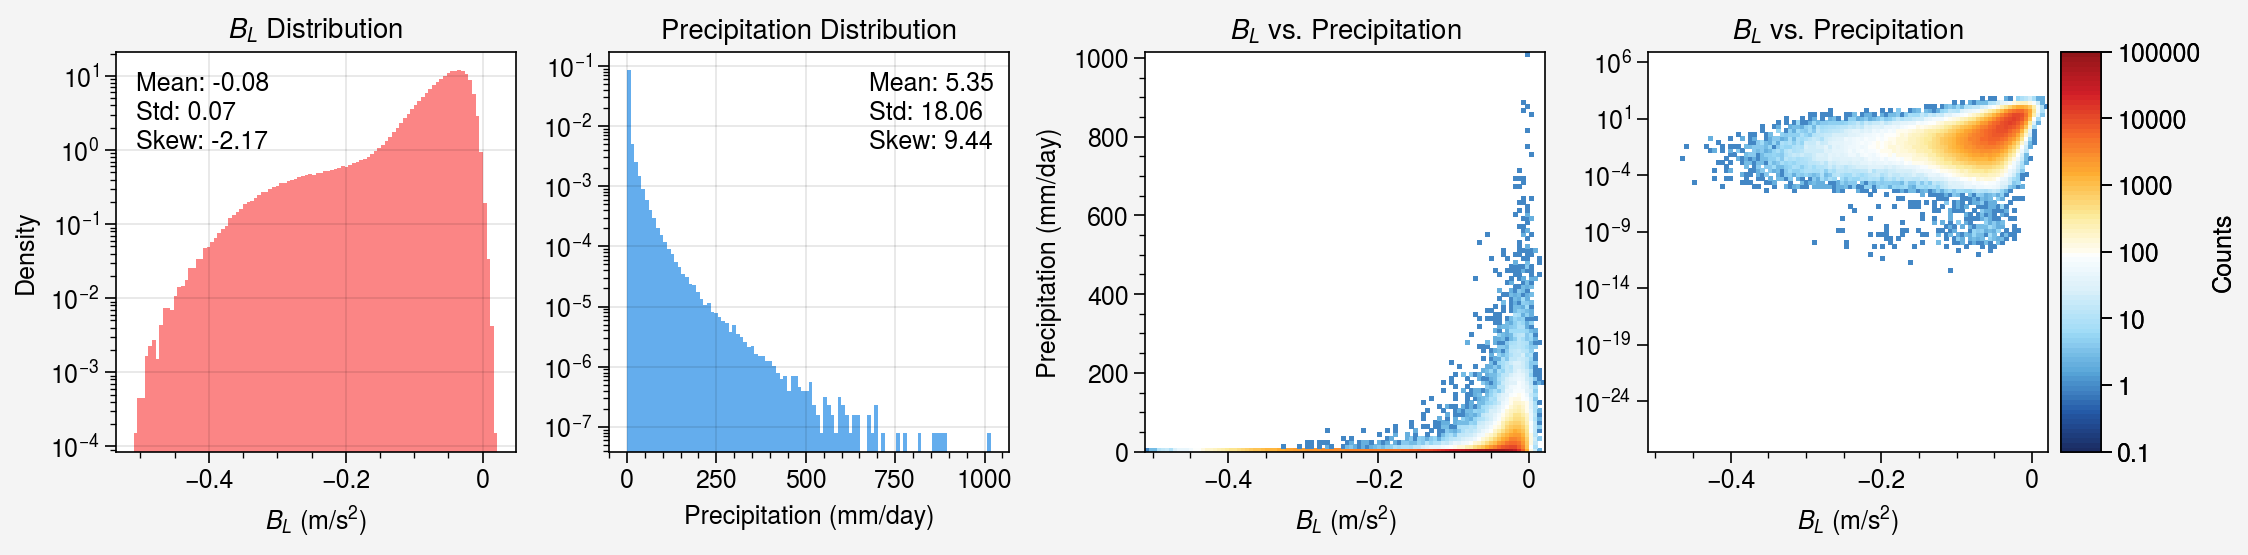

In [5]:
fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=2,share=False)
axs[0].format(title='$\mathit{B_L}$ Distribution',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Density',yscale='log',yformatter='log')
axs[1].format(title='Precipitation Distribution',xlabel='Precipitation (mm/day)',yscale='log',yformatter='log')
axs[2].format(title='$\mathit{B_L}$ vs. Precipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Precipitation (mm/day)')
axs[3].format(title='$\mathit{B_L}$ vs. Precipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',yscale='log',yformatter='log')

axs[0].hist(x,bins=bins,density=True,color='red6',alpha=0.7)
axs[1].hist(y,bins=bins,density=True,color='blue6',alpha=0.7)
statsx = f'Mean: {np.mean(x):.2f}\nStd: {np.std(x):.2f}\nSkew: {stats.skew(x):.2f}'
statsy = f'Mean: {np.mean(y):.2f}\nStd: {np.std(y):.2f}\nSkew: {stats.skew(y):.2f}'
axs[0].text(0.05,0.95,statsx,transform=axs[0].transAxes,va='top')
axs[1].text(0.65,0.95,statsy,transform=axs[1].transAxes,va='top')

hist,xedges,yedges = np.histogram2d(x,y,bins=(bins,bins))
hist = np.ma.masked_where(hist==0,hist)
mesh = axs[2].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)

xedges = np.linspace(np.min(x),np.max(x),bins+1)
yedges = np.logspace(np.log(np.min(y[y>0])),np.log(np.max(y)),bins+1)
hist,_,_ = np.histogram2d(x,y,bins=(xedges,yedges))
hist = np.ma.masked_where(hist==0,hist)
meshlog = axs[3].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)

axs[3].colorbar(meshlog,label='Counts',ticks=[0.1,1,10,100,1000,10000,100000])

pplt.show()

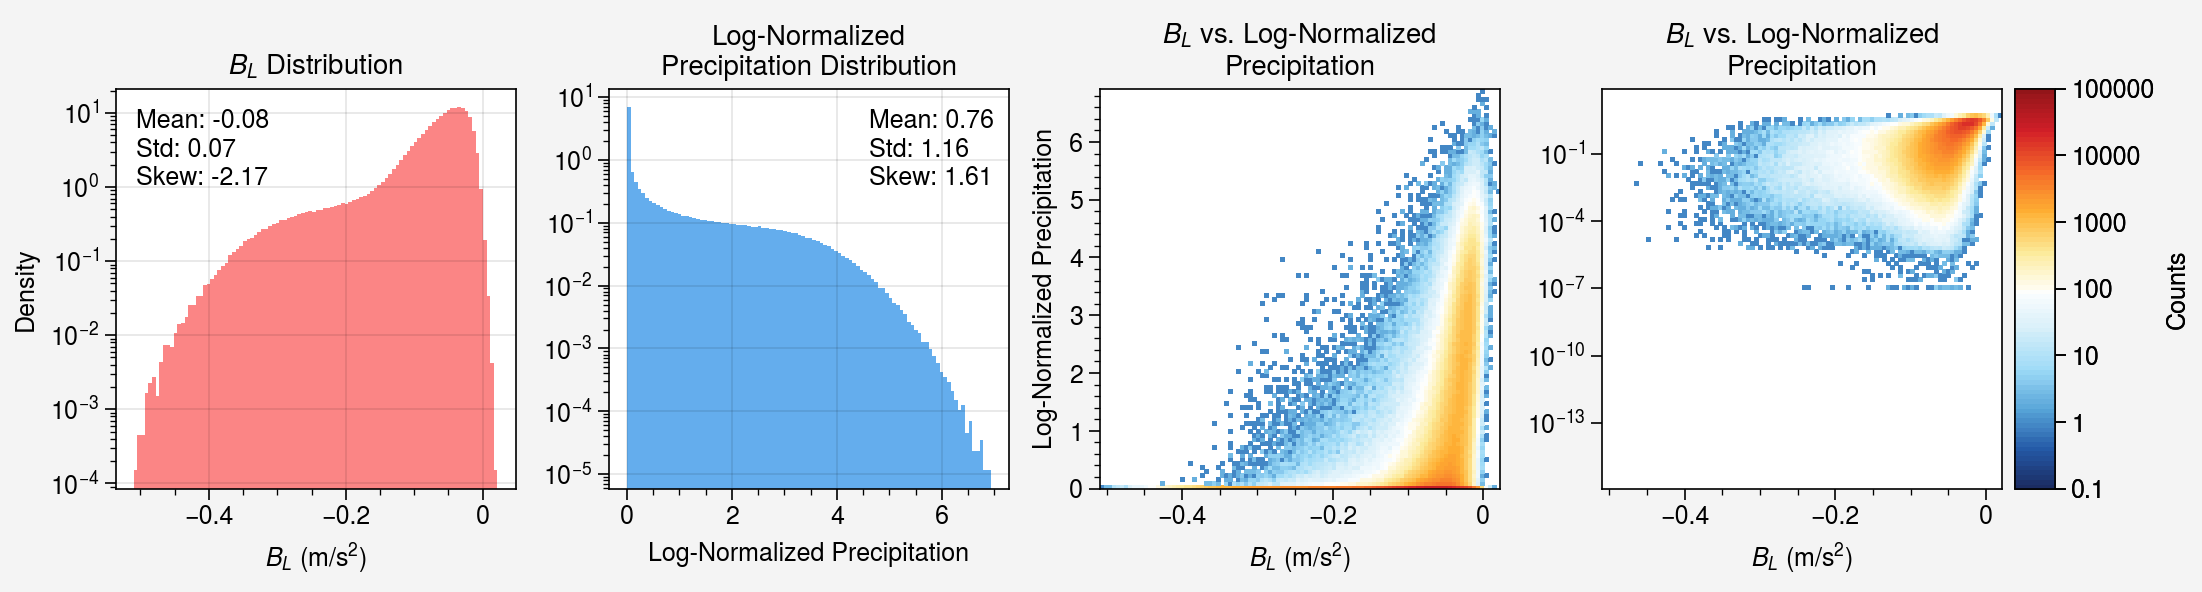

In [6]:
fig,axs = pplt.subplots(nrows=1,ncols=4,refwidth=2,share=False)
axs[0].format(title='$\mathit{B_L}$ Distribution',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Density',yscale='log',yformatter='log')
axs[1].format(title='Log-Normalized\nPrecipitation Distribution',xlabel='Log-Normalized Precipitation',yscale='log',yformatter='log')
axs[2].format(title='$\mathit{B_L}$ vs. Log-Normalized\nPrecipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',ylabel='Log-Normalized Precipitation')
axs[3].format(title='$\mathit{B_L}$ vs. Log-Normalized\nPrecipitation',xlabel='$\mathit{B_L}$ (m/s$^2$)',yscale='log',yformatter='log')

axs[0].hist(x,bins=bins,density=True,color='red6',alpha=0.7)
axs[1].hist(ylog,bins=bins,density=True,color='blue6',alpha=0.7)
statsx = f'Mean: {np.mean(x):.2f}\nStd: {np.std(x):.2f}\nSkew: {stats.skew(x):.2f}'
statsy = f'Mean: {np.mean(ylog):.2f}\nStd: {np.std(ylog):.2f}\nSkew: {stats.skew(ylog):.2f}'
axs[0].text(0.05,0.95,statsx,transform=axs[0].transAxes,va='top')
axs[1].text(0.65,0.95,statsy,transform=axs[1].transAxes,va='top')

hist,xedges,yedges = np.histogram2d(x,ylog,bins=(bins,bins))
hist = np.ma.masked_where(hist==0,hist)
mesh = axs[2].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)

xedges = np.linspace(np.min(x),np.max(x),bins+1)
yedges = np.logspace(np.log(np.min(ylog[ylog>0])),np.log(np.max(ylog)),bins+1)
hist,_,_ = np.histogram2d(x,ylog,bins=(xedges,yedges))
hist = np.ma.masked_where(hist==0,hist)
meshlog = axs[3].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)

axs[3].colorbar(meshlog,label='Counts',ticks=[0.1,1,10,100,1000,10000,100000])

pplt.show()

## Split Data

In [12]:
xtrain,xtest,ytrain,ytest = prepare(inputs=[bl,load('cape')],target=pr,testsize=0.2)

ytrainlog = ytrain.apply(lambda v:log_normalize(v,c=1.0))
ytestlog  = ytest.apply(lambda v:log_normalize(v,c=1.0))

## Analytical Baselines

### Model Class

In [43]:
class BASELINE:
    
    def __init__(self,binwidth,binmin,binmax,samplethresh):
        self.binwidth      = binwidth
        self.binmin        = binmin
        self.binmax        = binmax
        self.binedges      = np.arange(self.binmin,self.binmax+self.binwidth,self.binwidth)
        self.bincenters    = (self.binedges[:-1]+self.binedges[1:])/2
        self.nbins         = len(self.bincenters)
        self.samplethresh  = samplethresh
        self.model         = None

    def fit(self,inputs,targets):
        idxs  = np.digitize(inputs,self.binedges)-1
        Q0,Q1 = np.zeros(self.nbins),np.zeros(self.nbins)
        for i in range(targets.size):
            idx    = idxs[i]
            target = targets[i]
            if 0<=idx<self.nbins and np.isfinite(target):
                Q0[idx] += 1
                Q1[idx] += target
        with np.errstate(divide='ignore',invalid='ignore'):
            self.model = np.where(Q0>=self.samplethresh,Q1/Q0,np.nan)
        return (self.bincenters,self.model)

    def predict(self,inputs):
        binidxs = np.clip(np.digitize(inputs,self.binedges)-1,0,self.nbins-1)
        outputs = self.model[binidxs]
        outputs = np.maximum(outputs,0) # Enforce non-negative constraint
        return outputs
    
    # def evaluate(self,outputs,targets):
    #     mask    = ~np.isnan(outputs)&~np.isnan(targets)
    #     outputs = torch.FloatTensor(outputs[mask])
    #     targets = torch.FloatTensor(targets[mask])
    #     loss    = self.criterion(outputs,targets).item()
    #     return loss

### Train Baselines

In [44]:
configs = [
    {'binwidth':0.1,
     'description':'Binwidth = 0.1'},
    {'binwidth':0.01,  
     'description':'Binwidth = 0.01'},
    {'binwidth':0.001,   
     'description':'Binwidth = 0.001'}]

baselineresults = {}
for config in configs:
    print(f'Training {config["description"]}')
    baseline = BASELINE(
        binwidth=config['binwidth'],
        binmin=-0.6,
        binmax=0.1,
        samplethresh=50)
    baselinemodel   = baseline.fit(xtrain['bl'].values,ytrain['pr'].values)
    baselineoutputs = baseline.predict(xtest['bl'].values)
    baselineresults[f'binwidth_{config["binwidth"]}'] = {
        'description':config['description'],
        'binwidth':config['binwidth'],
        'bincenters':baseline.bincenters, 
        'binmeans':baseline.model, 
        'testoutputs':baselineoutputs}

Training Binwidth = 0.1
Training Binwidth = 0.01
Training Binwidth = 0.001


## MLPs

### Model Class

In [45]:
class MLPMODEL(torch.nn.Module):
    
    def __init__(self,inputsize,hiddensize,outputsize,nhiddenlayers,activation=None):
        super(MLPMODEL,self).__init__()    
        self.inputsize     = inputsize
        self.hiddensize    = hiddensize
        self.outputsize    = outputsize
        self.nhiddenlayers = nhiddenlayers
        self.activation    = activation if activation is not None else torch.nn.Identity()
        layers = []
        layers.append(torch.nn.Linear(inputsize,hiddensize))
        layers.append(self.activation)
        for _ in range(nhiddenlayers-1):
            layers.append(torch.nn.Linear(hiddensize,hiddensize))
            layers.append(self.activation)
        layers.append(torch.nn.Linear(hiddensize,outputsize))
        self.layers = torch.nn.Sequential(*layers)
    def forward(self,x):
        return self.layers(x)

class MLP:
    
    def __init__(self,inputsize,hiddensize,outputsize,nhiddenlayers,activation,criterion,learningrate,nepochs,batchsize,validsplit,patience,randomstate,logtransform=False):
        self.model        = MLPMODEL(inputsize,hiddensize,outputsize,nhiddenlayers,activation)
        self.criterion    = criterion
        self.optimizer    = torch.optim.Adam(self.model.parameters(),lr=learningrate)
        self.nepochs      = nepochs
        self.batchsize    = batchsize
        self.validsplit   = validsplit
        self.patience     = patience
        self.randomstate  = randomstate
        self.logtransform = logtransform
        self.device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def _tensor(self,data):
        if isinstance(data,pd.DataFrame):
            return torch.FloatTensor(data.values)
        elif isinstance(data,pd.Series):
            return torch.FloatTensor(data.values.reshape(-1,1))
        elif isinstance(data,np.ndarray):
            if data.ndim==1:
                return torch.FloatTensor(data.reshape(-1,1))
            return data
        elif isinstance(data,list):
            return torch.FloatTensor(np.array(data).reshape(-1,1))
        else:
            raise ValueError('Unsupported data type. Please provide a pd.DataFrame, pd.Series, np.ndarray, or list.')   

    def fit(self,inputs,targets):
        inputs  = self._tensor(inputs)
        targets = self._tensor(targets)
        xtrain,xvalid,ytrain,yvalid = train_test_split(inputs,targets,test_size=self.validsplit,random_state=self.randomstate)
        traindataset = TensorDataset(xtrain,ytrain)
        validdataset = TensorDataset(xvalid,yvalid)
        trainloader  = DataLoader(traindataset,batch_size=self.batchsize,shuffle=True)
        validloader  = DataLoader(validdataset,batch_size=self.batchsize,shuffle=False)
        trainlosses = []
        validlosses = []
        if self.logtransform:
            trainlossesbt = []
            validlossesbt = []
        bestvalidloss   = float('inf')
        patiencecounter = 0
        for epoch in range(self.nepochs):
            self.model.train()
            trainloss   = 0.0
            trainlossbt = 0.0
            for batchinputs,batchtargets in trainloader:
                self.optimizer.zero_grad()
                batchoutputs = self.model(batchinputs)
                batchloss    = self.criterion(batchoutputs,batchtargets)
                batchloss.backward()
                self.optimizer.step()
                trainloss += batchloss.item()*batchinputs.size(0)
                if self.logtransform:
                    outputsbt = torch.exp(batchoutputs)-1
                    targetsbt = torch.exp(batchtargets)-1
                    batchlossbt = self.criterion(outputsbt,targetsbt)
                    trainlossbt += batchlossbt.item()*batchinputs.size(0)     
            trainloss /= len(trainloader.dataset)
            trainlosses.append(trainloss) 
            if self.logtransform:
                trainlossbt /= len(trainloader.dataset)
                trainlossesbt.append(trainlossbt)
            self.model.eval()
            validloss   = 0.0
            validlossbt = 0.0
            with torch.no_grad():
                for batchinputs,batchtargets in validloader:
                    batchoutputs = self.model(batchinputs)
                    batchloss    = self.criterion(batchoutputs,batchtargets)
                    validloss   += batchloss.item()*batchinputs.size(0)
                    if self.logtransform:
                        outputsbt = torch.exp(batchoutputs)-1
                        targetsbt = torch.exp(batchtargets)-1
                        batchlossbt = self.criterion(outputsbt,targetsbt)
                        validlossbt += batchlossbt.item()*batchinputs.size(0)            
            validloss /= len(validloader.dataset)
            validlosses.append(validloss)
            if self.logtransform:
                validlossbt /= len(validloader.dataset)
                validlossesbt.append(validlossbt)
            if self.logtransform:
                print(f'Epoch {epoch+1}/{self.nepochs} - Training Loss: {trainloss:.4f} (log),{trainlossbt:.4f} - Validation Loss: {validloss:.4f} (log), {validlossbt:.4f}')
            else:
                print(f'Epoch {epoch+1}/{self.nepochs} - Training Loss: {trainloss:.4f}, Validation Loss: {validloss:.4f}')
            if validloss<bestvalidloss:
                bestvalidloss   = validloss
                patiencecounter = 0
                torch.save(self.model.state_dict(),'best_model.pth')
            else:
                patiencecounter += 1
                if patiencecounter>=self.patience:
                    print(f'Early stopping triggered after {epoch+1} epochs!')
                    self.model.load_state_dict(torch.load('best_model.pth'))
                    break
        if self.logtransform:
            return (trainlosses,validlosses,trainlossesbt,validlossesbt)
        else:
            return (trainlosses,validlosses)

    def predict(self,inputs):
        inputs  = self._tensor(inputs).to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(inputs)
        return outputs.cpu().numpy()

    def evaluate(self,inputs,targets):
        inputs  = self._tensor(inputs).to(self.device)
        targets = self._tensor(targets).to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(inputs)
            loss    = self.criterion(outputs,targets).item()
        return loss

### Train MLPs

In [47]:
configs = [
    {'name':'linear_mse',
     'activation':torch.nn.Identity(),
     'criterion':torch.nn.MSELoss(),
     'logtransform':False,
     'description':'Linear MSE'},
    {'name':'linear_mae',
     'activation':torch.nn.Identity(), 
     'criterion':torch.nn.L1Loss(),   
     'logtransform':False,
     'description':'Linear MAE'},
    {'name':'relu_mse',
     'activation':torch.nn.ReLU(),
     'criterion':torch.nn.MSELoss(),
     'logtransform':False,
     'description':'Nonlinear MSE'},
    {'name':'relu_mae',
     'activation':torch.nn.ReLU(),
     'criterion':torch.nn.L1Loss(),
     'logtransform':False,
     'description':'Nonlinear MAE'},
    {'name':'linear_mse_log',
     'activation':torch.nn.Identity(),
     'criterion':torch.nn.MSELoss(),
     'logtransform':True,
     'description':'Log-Normalized Linear MSE'},
    {'name':'linear_mae_log',
     'activation':torch.nn.Identity(), 
     'criterion':torch.nn.L1Loss(), 
     'logtransform':True,
     'description':'Log-Normalized Linear MAE'},
    {'name':'relu_mse_log',
     'activation':torch.nn.ReLU(),
     'criterion':torch.nn.MSELoss(),
     'logtransform':True,
     'description':'Log-Normalized Nonlinear MSE'},
    {'name':'relu_mae_log',
     'activation':torch.nn.ReLU(),
     'criterion':torch.nn.L1Loss(),
     'logtransform':True,
     'description':'Log-Normalized Nonlinear MAE'}]

mlpresults  = {}
for config in configs:
    print(f"\nTraining {config['description']}")
    print(f"{'='*60}")
    mlp = MLP(
        inputsize=xtrain.shape[1], 
        hiddensize=64, 
        outputsize=ytrain.shape[1], 
        nhiddenlayers=1,
        activation=config['activation'],
        criterion=config['criterion'],
        learningrate=0.001,
        nepochs=50,
        batchsize=500,
        validsplit=0.25,
        patience=2,
        randomstate=42,
        logtransform=config['logtransform'])
    if config['logtransform']==True:
        _,_,trainlossesbt,validlossesbt = mlp.fit(xtrain['bl'].values,ytrainlog['pr'].values)
        modelfilename = f'best_model_{config["name"]}.pth'
        torch.save(mlp.model.state_dict(),modelfilename)
        print(f"Model saved as: {modelfilename}")
        testoutputs = mlp.predict(xtest['bl'].values)
        testloss    = mlp.evaluate(xtest['bl'].values,ytestlog['pr'].values)
        mlpresults[config['name']] = {
            'trainlosses':trainlossesbt,
            'validlosses':validlossesbt,
            'testoutputs':testoutputs,
            'testloss':testloss,
            'modelfile':modelfilename,
            'description':config['description'],
            'logtransform':config['logtransform']}    
    elif config['logtransform']==False:
        trainlosses,validlosses = mlp.fit(xtrain['bl'].values,ytrain['pr'].values)
        modelfilename = f'best_model_{config["name"]}.pth'
        torch.save(mlp.model.state_dict(),modelfilename)
        print(f"Model saved as: {modelfilename}")
        testoutputs = mlp.predict(xtest['bl'].values)
        testloss    = mlp.evaluate(xtest['bl'].values,ytest['pr'].values)
        mlpresults[config['name']] = {
            'trainlosses':trainlosses,
            'validlosses':validlosses,
            'testoutputs':testoutputs,
            'testloss':testloss,
            'modelfile':modelfilename,
            'description':config['description'],
            'logtransform':config['logtransform']}


Training Linear MSE
Epoch 1/50 - Training Loss: 326.3973, Validation Loss: 317.7307
Epoch 2/50 - Training Loss: 318.4032, Validation Loss: 317.6918
Epoch 3/50 - Training Loss: 318.3983, Validation Loss: 317.6379
Epoch 4/50 - Training Loss: 318.3971, Validation Loss: 317.6252
Epoch 5/50 - Training Loss: 318.3993, Validation Loss: 317.8428
Epoch 6/50 - Training Loss: 318.4091, Validation Loss: 317.6271
Early stopping triggered after 6 epochs!
Model saved as: best_model_linear_mse.pth

Training Linear MAE
Epoch 1/50 - Training Loss: 5.3435, Validation Loss: 5.3249
Epoch 2/50 - Training Loss: 5.3429, Validation Loss: 5.3249
Epoch 3/50 - Training Loss: 5.3429, Validation Loss: 5.3257
Early stopping triggered after 3 epochs!
Model saved as: best_model_linear_mae.pth

Training Nonlinear MSE
Epoch 1/50 - Training Loss: 327.3263, Validation Loss: 316.0621
Epoch 2/50 - Training Loss: 313.1764, Validation Loss: 308.5002
Epoch 3/50 - Training Loss: 303.4970, Validation Loss: 297.0449
Epoch 4/50 -

### Training/Validation Plot

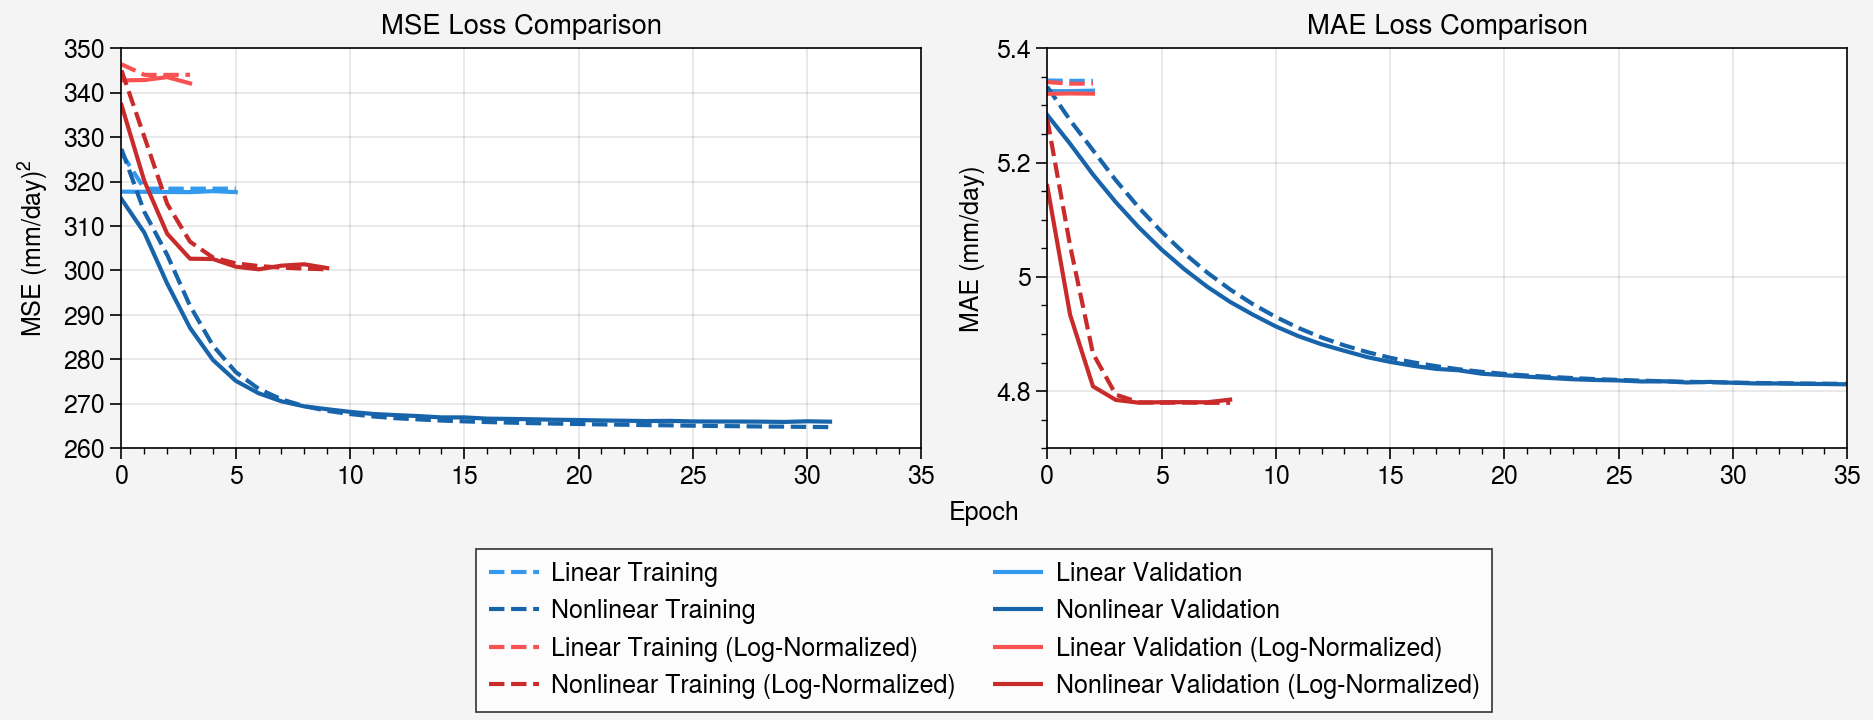

In [48]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=4,refheight=2,sharex=True,sharey=False)
axs.format(xlabel='Epoch',xlim=(0,35))
axs[0].format(title='MSE Loss Comparison',ylabel='MSE (mm/day)$^2$',ylim=(260,350),yticks=10,yminorticks='none')
axs[1].format(title='MAE Loss Comparison',ylabel='MAE (mm/day)',ylim=(4.7,5.4))
colors = ['blue5','blue9','red6','red9']
for i,(ax,loss) in enumerate(zip(axs,['mse','mae'])):
    ax.plot(mlpresults[f'linear_{loss}']['trainlosses'],color=colors[0],linestyle='--',label='Linear Training' if i==0 else None)
    ax.plot(mlpresults[f'linear_{loss}']['validlosses'],color=colors[0],linestyle='-',label='Linear Validation' if i==0 else None)
    ax.plot(mlpresults[f'relu_{loss}']['trainlosses'],color=colors[1],linestyle='--',label='Nonlinear Training' if i==0 else None)
    ax.plot(mlpresults[f'relu_{loss}']['validlosses'],color=colors[1],linestyle='-',label='Nonlinear Validation' if i==0 else None)
    ax.plot(mlpresults[f'linear_{loss}_log']['trainlosses'],color=colors[2],linestyle='--',label='Linear Training (Log-Normalized)' if i==0 else None)
    ax.plot(mlpresults[f'linear_{loss}_log']['validlosses'],color=colors[2],linestyle='-',label='Linear Validation (Log-Normalized)' if i==0 else None)
    ax.plot(mlpresults[f'relu_{loss}_log']['trainlosses'],color=colors[3],linestyle='--',label='Nonlinear Training (Log-Normalized)' if i==0 else None)
    ax.plot(mlpresults[f'relu_{loss}_log']['validlosses'],color=colors[3],linestyle='-',label='Nonlinear Validation (Log-Normalized)' if i==0 else None)
fig.legend(loc='b',ncols=2)
pplt.show()

## Clean & Format Model Outputs

In [ ]:
prlist   = {}
ytrueraw = ytest['pr'].values

for modelname,result in mlpresults.items():
    if result.get('logtransform',False):
        ypredraw = inverse_log_normalize(result['testoutputs'],c=1.0)
    else:
        ypredraw = result['testoutputs']
    mask = (ytrueraw>0)&(ypredraw>0)&~np.isnan(ytrueraw)&~np.isnan(ypredraw)
    prlist[modelname] = {
        'ytrue':ytrueraw[mask],
        'ypred':ypredraw[mask],
        'description':result['description']}

for modelname,result in baselineresults.items():
    ypredraw = result['testoutputs']
    mask = (ytrueraw>0)&(ypredraw>0)&~np.isnan(ytrueraw)&~np.isnan(ypredraw)
    prlist[modelname] = {
        'ytrue':ytrueraw[mask],
        'ypred':ypredraw[mask],
        'description':result['description']}

## Plot Actual vs. Predicted Precipitation

In [ ]:
allytrue = np.concatenate([pr['ytrue'] for pr in prlist.values()])
allypred = np.concatenate([pr['ypred'] for pr in prlist.values()])
globalmin = min(allytrue.min(),allypred.min())
globalmax = max(allytrue.max(),allypred.max())
globalmin = globalmin/(10**(0.1*(np.log10(globalmax)-np.log10(globalmin))))
globalmax = globalmax*(10**(0.1*(np.log10(globalmax)-np.log10(globalmin))))

totalmodels = len(prlist)
ncols = 4
nrows = (totalmodels+ncols-1)//ncols

fig, axs = pplt.subplots(nrows=nrows, ncols=ncols, refwidth=2, share=True)
axs.format(xlabel='True Precipitation (mm/day)', xscale='log', xformatter='log', xlim=[globalmin, globalmax],
           ylabel='Predicted Precipitation (mm/day)', yscale='log', yformatter='log', ylim=[globalmin, globalmax])

bins = 100
xedges = np.logspace(np.log10(globalmin), np.log10(globalmax), bins + 1)
yedges = np.logspace(np.log10(globalmin), np.log10(globalmax), bins + 1)

for plotidx, (modelname, data) in enumerate(processed_data.items()):
    row = plotidx // ncols
    col = plotidx % ncols
    
    ytrue = data['ytrue']
    ypred = data['ypred']
    
    # Ensure equal lengths
    minlen = min(len(ytrue), len(ypred))
    ytrue = ytrue[:minlen]
    ypred = ypred[:minlen]
    
    # Create histogram
    hist, _, _ = np.histogram2d(ytrue, ypred, bins=(xedges, yedges))
    hist = np.ma.masked_where(hist == 0, hist)
    
    # Plot
    mesh = axs[row, col].pcolormesh(xedges, yedges, hist.T, cmap='ColdHot', norm='log', levels=100)
    axs[row, col].plot([globalmin, globalmax], [globalmin, globalmax], color='k', linestyle='--')
    axs[row, col].format(title=data['description'])
    
    # Calculate and display R²
    r2 = r2_score(ytrue, ypred)
    axs[row, col].text(0.05, 0.90, f'R$^2$ = {r2:.3f}', transform=axs[row, col].transAxes)

# Hide unused subplots
for i in range(len(processed_data), nrows * ncols):
    row = i // ncols
    col = i % ncols
    axs[row, col].axis('off')

fig.colorbar(mesh, loc='r', label='Counts', ticks=[0.1, 1, 10, 100, 1000, 10000, 100000])
pplt.show()

In [ ]:
allytrue = []
allypred = []

for modelname,result in mlpresults.items():
    ytrue = ytest['pr'].values
    if result.get('logtransform',False):
        ypred = inverse_log_normalize(result['testoutputs'],c=1.0)
    else:
        ypred = result['testoutputs']
    allytrue.extend(np.array(ytrue).flatten())
    allypred.extend(np.array(ypred).flatten())

for modelname,result in baselineresults.items():
    ytrue = ytest['pr'].values
    ypred = result['testoutputs']
    allytrue.extend(np.array(ytrue).flatten())
    allypred.extend(np.array(ypred).flatten())

allytrue = np.array(allytrue)
allypred = np.array(allypred)
allytrue = allytrue[allytrue>0]
allypred = allypred[allypred>0]
globalmin = min(allytrue.min(),allypred.min())
globalmax = max(allytrue.max(),allypred.max())
globalmin = globalmin/(10**(0.1*(np.log10(globalmax)-np.log10(globalmin))))
globalmax = globalmax*(10**(0.1*(np.log10(globalmax)-np.log10(globalmin))))

totalmodels = len(mlpresults)+len(baselineresults)
ncols = 4
nrows = (totalmodels+ncols-1)//ncols

In [ ]:
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=2,share=True)
axs.format(xlabel='True Precipitation (mm/day)',xscale='log',xformatter='log',xlim=[globalmin,globalmax],
           ylabel='Predicted Precipitation (mm/day)',yscale='log',yformatter='log',ylim=[globalmin,globalmax])
plotidx = 0
bins    = 100

for modelname,result in mlpresults.items():
    row   = plotidx//ncols
    col   = plotidx%ncols
    ytrue = ytest['pr'].values
    if result.get('logtransform',False):
        ypred = inverse_log_normalize(result['testoutputs'],c=1.0)
    else:
        ypred = result['testoutputs']
    ytrue = np.array(ytrue).flatten()
    ypred = np.array(ypred).flatten()
    mask  = (ytrue>0)&(ypred>0)
    ytrue = ytrue[mask]
    ypred = ypred[mask]
    minlen = min(len(ytrue),len(ypred))
    ytrue  = ytrue[:minlen]
    ypred  = ypred[:minlen]
    xedges = np.logspace(np.log10(globalmin),np.log10(globalmax),bins+1)
    yedges = np.logspace(np.log10(globalmin),np.log10(globalmax),bins+1)
    hist,_,_ = np.histogram2d(ytrue,ypred,bins=(xedges,yedges))
    hist = np.ma.masked_where(hist==0,hist)
    mesh = axs[row,col].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)
    axs[row,col].plot([globalmin,globalmax],[globalmin,globalmax],color='k',linestyle='--')
    axs[row,col].format(title=result['description'])
    r2 = r2_score(ytrue,ypred)  
    axs[row,col].text(0.05,0.90,f'R$^2$ = {r2:.3f}',transform=axs[row,col].transAxes)
    plotidx += 1

for modelname,result in baselineresults.items():
    row = plotidx//ncols
    col = plotidx%ncols
    ytrue = np.array(ytest['pr'].values).flatten()
    ypred = np.array(result['testoutputs']).flatten()
    mask  = (ytrue>0)&(ypred>0)
    ytrue = ytrue[mask]
    ypred = ypred[mask]
    minlen = min(len(ytrue),len(ypred))
    ytrue = ytrue[:minlen]
    ypred = ypred[:minlen]
    xedges = np.logspace(np.log10(globalmin),np.log10(globalmax),bins+1)
    yedges = np.logspace(np.log10(globalmin),np.log10(globalmax),bins+1)
    hist,_,_ = np.histogram2d(ytrue,ypred,bins=(xedges,yedges))
    hist = np.ma.masked_where(hist==0,hist)
    mesh = axs[row,col].pcolormesh(xedges,yedges,hist.T,cmap='ColdHot',norm='log',levels=100)
    axs[row,col].plot([globalmin,globalmax],[globalmin,globalmax],color='k',linestyle='--')
    axs[row,col].format(title=result['description'])
    r2 = r2_score(ytrue,ypred)  
    axs[row,col].text(0.05,0.90,f'R$^2$ = {r2:.3f}',transform=axs[row,col].transAxes)
    plotidx += 1

for i in range(plotidx,nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')

fig.colorbar(mesh,loc='r',label='Counts',ticks=[0.1,1,10,100,1000,10000,100000])
pplt.show()

## Calculate Metrics

In [ ]:
def calc_metrics(ytrue,ypred):
    mask = ~np.isnan(ytrue)&~np.isnan(ypred)
    ytrueclean = ytrue[mask]
    ypredclean = ypred[mask]
    metrics = {}
    metrics['MSE']  = mean_squared_error(ytrueclean,ypredclean)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['MAE']  = mean_absolute_error(ytrueclean,ypredclean)
    metrics['R2']   = r2_score(ytrueclean,ypredclean)
    return metrics

In [ ]:
allmetrics = {}
for modeldict in [baselineresults,mlpresults]:
    for modelname,result in modeldict.items():
        ytrue = ytest['pr'].values
        if modeldict==regresults or modeldict==baselineresults:
            ypred = result['testoutputs']
        elif modeldict==logresults:
            ypred = inverse_log_normalize(result['testoutputs'],c=1.0)
        metrics = calc_metrics(ytrue,ypred)
        metrics['Title'] = result['description']
        allmetrics[modelname] = metrics
        
metricsdf = pd.DataFrame.from_dict(allmetrics,orient='index')
metricsdf